In [1]:
import tensorflow as tf
import os
import cv2
import shutil
import random
import pandas as pd

import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Dropout, Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BASE_DIR = "../DetectedFace/train"
BASE_DIR2 = "../DetectedFace/test"
TRAIN_PIC_CF_DIR = "../DetectedFace/train/cf/" #real human face pic dir
TRAIN_PIC_IF_DIR = "../DetectedFace/train/if/" #impose human face pic dir

cf_pic_list = os.listdir(TRAIN_PIC_CF_DIR)
if_pic_list = os.listdir(TRAIN_PIC_IF_DIR)

random.shuffle(cf_pic_list) # random file cf
random.shuffle(if_pic_list) # random file if

'''
for file_name in cf_pic_list[:2500]:
    shutil.move(TRAIN_PIC_CF_DIR + file_name, BASE_DIR2 + "/cf")
for file_name in if_pic_list[:3500]:
    shutil.move(TRAIN_PIC_IF_DIR + file_name, BASE_DIR2 + "/if")
'''

'\nfor file_name in cf_pic_list[:2500]:\n    shutil.move(TRAIN_PIC_CF_DIR + file_name, BASE_DIR2 + "/cf")\nfor file_name in if_pic_list[:3500]:\n    shutil.move(TRAIN_PIC_IF_DIR + file_name, BASE_DIR2 + "/if")\n'

In [3]:
img_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20).flow_from_directory(BASE_DIR, target_size=(224, 224), batch_size=32)
img_gen_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20).flow_from_directory(BASE_DIR2, target_size=(224, 224), batch_size=32)
img_gen_test

Found 3225 images belonging to 2 classes.
Found 9389 images belonging to 2 classes.


In [4]:
mobile_net = tensorflow.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False,input_tensor=Input(shape=(224,224,3)))

In [5]:
for layer in mobile_net.layers[:-3]:
    layer.trainable = False

In [9]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(mobile_net)
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              25089000  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2002      
Total params: 39,805,690
Trainable params: 29,810,618
Non-trainable params: 9,995,072
_________________________________________________________________


In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.Adam(lr=1e-5),
              metrics=['acc'],batch_size=32)

model.fit_generator(generator=img_gen_train,epochs=3)

Epoch 1/3
101/101 [==============================] - 39s 390ms/step - loss: 0.1296 - acc: 0.9491
Epoch 2/3
101/101 [==============================] - 39s 390ms/step - loss: 0.0141 - acc: 0.9972
Epoch 3/3
101/101 [==============================] - 40s 392ms/step - loss: 0.0071 - acc: 0.9984


In [ ]:
model.fit_generator(generator=img_gen_train,epochs=10)

In [11]:
model.evaluate_generator(img_gen_test)

[0.11700291058276685, 0.9597401]

In [12]:
result = []
pl = predict_array.tolist()
for p in pl:
    if p[0] > p[1]:
        result.append(1)
    else:
        result.append(0)

NameError: name 'predict_array' is not defined

In [22]:
model.save("vgg-unti-spoofing.h5")

In [13]:
def plots(ims, figsize=(24,12), rows=4, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=32)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

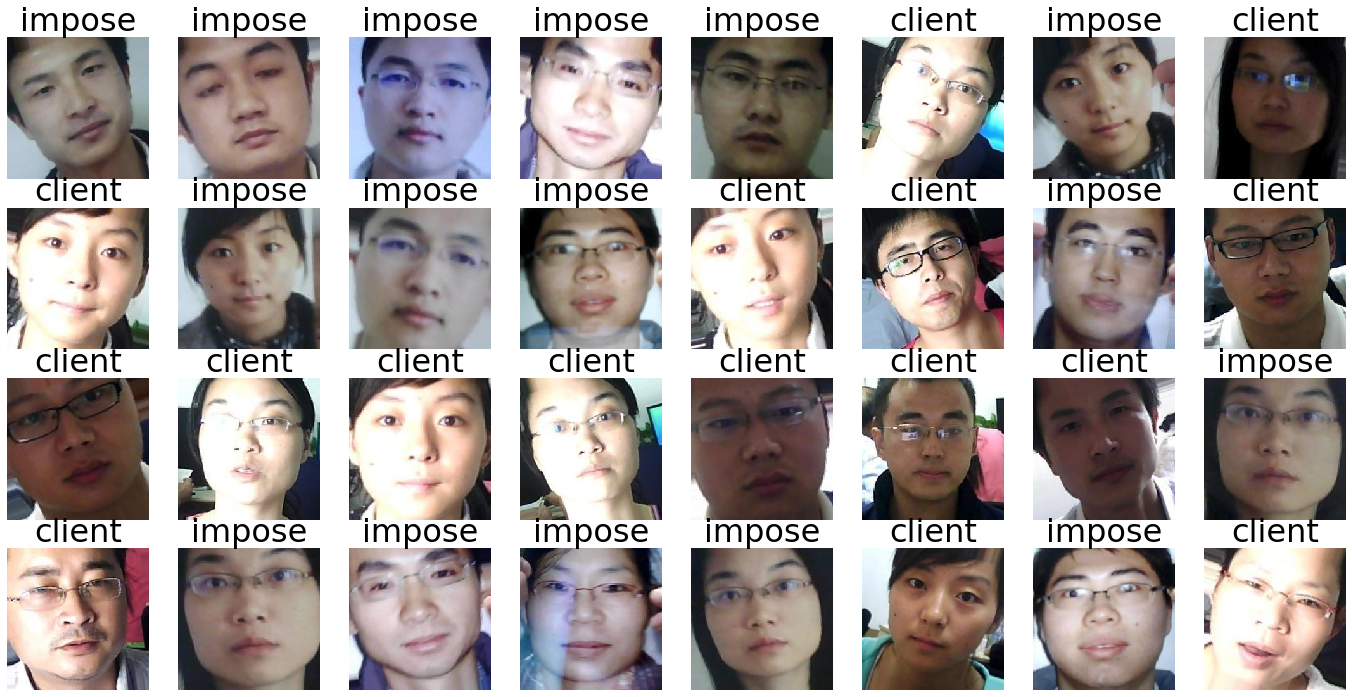

In [14]:
def to_label(value):
    if value==0:
        return 'client'
    else:
        return 'impose'
test_imgs, test_labels = next(img_gen_test)
predictions = model.predict(test_imgs)

df = pd.DataFrame()
df['actual'] = test_labels[:,1]
df['predicted'] = np.round(predictions[:,1])
df['predicted_labels']=df['predicted'].map(lambda x: to_label(x))
df['actual_labels']=df['actual'].map(lambda x: to_label(x))
plots(test_imgs*255, titles=df['actual_labels'])